# Preprocessing with some EDA

In [1]:
# Package Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
불필요한 열 제거, 특정 ID 변수를 categorical type으로 변경

In [2]:
# 불필요한 열
col_notuse = ['ADID', '노출 ID', 'SSP 입찰ID', 'DSP 입찰ID', 'AX 낙찰ID', 'WUID (웹 유저 ID)', '광고 응답 광고주 도메인','OS 버전 ID']
col_use = ['시각', 'ADID 타입', 'DSP ID', '매체 ID', '애드유닛 ID', '플랫폼', 'OS 종류', '사이즈 ID',
       '환율', '광고 응답 소재 카테고리', '국가코드 ID', 'P1', 'P2', 'P3', 'P4', 'P5',
       'winning']

In [3]:
# # chunk to pickle(train dataset)
# tp = pd.read_csv('dataset_round1/round1_train.csv', iterator=True, chunksize=1000000)
# df = pd.concat(tp, ignore_index=True)
# # df.to_pickle('train_full.pkl')

In [4]:
# # Data Load/save는 pickle format 이용함
# df = pd.read_pickle('train_full.pkl')

전체 데이터 중
* 낙찰 O : 약 200만개
* 낙찰 X : 약 530만개

> binary classification

### 불필요한 열 제거

In [5]:
# df.columns

In [6]:
# for col in df.columns[:-6]:
#     print(f'Unique values of column {col} : {len(df[col].unique())}')

불필요한 열 선정 결과

> Drop cols : ADID, 노출 ID, SSP 입찰ID, DSP 입찰ID, AX 낙찰ID, WUID (웹 유저 ID), 도메인, OS 버전 ID

In [7]:
# df_cols = df.columns.drop(col_notuse)

In [8]:
# df = df[df_cols]

In [9]:
# df.to_pickle('train.pkl') # 4.3s(compressed)

### ID cols to categorical coding

In [10]:
df = pd.read_csv('dataset_round1/round1_train.csv', usecols=col_use) # 34.3s

In [11]:
df_test = pd.read_csv('dataset_round1/round1_test.csv', usecols=df.columns.drop(['P5','winning']))

In [12]:
# DSP ID, 매체 ID, 애드유닛 ID to categorical(from ID to integer)
col_cat = ['DSP ID', '매체 ID', '애드유닛 ID']

In [13]:
from pandas.api.types import CategoricalDtype
from copy import deepcopy

for col in col_cat:
    series_whole = pd.concat([df[col],df_test[col]]).astype('category').cat.codes + 1
    df[col] = series_whole[:len(df)]
    df_test[col] = series_whole[len(df):]

In [14]:
df = df.sort_values(by=['시각','winning'])
df_test = df_test.sort_values(by=['시각'])

In [15]:
df = df.reset_index(drop=True)

In [16]:
df.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl') # 1.6s

## EDA

In [17]:
# Data Load
df_train = pd.read_pickle('train.pkl')
df_train = df_train[df_train.columns.drop(['P5'])] # P5는 사용불가능한 변수이므로 제거

df_test = pd.read_pickle('test.pkl')

In [18]:
col_price = ['P1','P2','P3','P4']

In [19]:
df_train.loc[df_train.winning==1.0, col_price].corr() # 가격변수간 상관계수 탐색(낙찰)

,P1,P2,P3,P4
P1,1.000000,0.576665,0.636191,0.999999
P2,0.576665,1.000000,0.946439,0.576608
P3,0.636191,0.946439,1.000000,0.636141
P4,0.999999,0.576608,0.636141,1.000000


In [20]:
df_train.loc[df_train.winning==0.0, col_price].corr() # 가격변수간 상관계수 탐색(유찰)

,P1,P2,P3,P4
P1,1.000000,0.709176,0.710066,0.999561
P2,0.709176,1.000000,0.996453,0.719102
P3,0.710066,0.996453,1.000000,0.719804
P4,0.999561,0.719102,0.719804,1.000000


In [21]:
df_train.to_pickle('train.pkl')
df_test.to_pickle('test.pkl')

### To Datetime
일시 및 초단위 시각을 직접 사용하는 것은 현재 Classification 문제에서 벗어난 Time-series analysis의 관점이므로 일부 변수로만 추출해서 진행

In [22]:
df_train = pd.read_pickle('train.pkl')
df_test = pd.read_pickle('test.pkl')

In [23]:
df_train.시각 = pd.to_datetime(df_train.시각, format='%Y%m%d%H%M%S')
df_test.시각 = pd.to_datetime(df_test.시각, format='%Y%m%d%H%M%S')

In [24]:
df_train.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl') # 1.6s

In [25]:
# Variable Extraction
## 주말여부
df_train['weekend'] = df_train.시각.dt.dayofweek > 4
df_train['weekend'] = df_train['weekend'].astype('int')
df_test['weekend'] = df_test.시각.dt.dayofweek > 4
df_test['weekend'] = df_test['weekend'].astype('int')

In [26]:
## 시간대
df_train['hour'] = df_train.시각.dt.hour
df_test['hour'] = df_test.시각.dt.hour

In [27]:
## 요일
df_train['dayofweek'] = df_train.시각.dt.dayofweek
df_test['dayofweek'] = df_test.시각.dt.dayofweek

In [28]:
df_train.to_pickle('train.pkl')
df_test.to_pickle('test.pkl')

### Visualization
- Kernel Density Estimation plot으로 가격변수의 분포 확인

In [29]:
df_win = df_train[df_train.winning==1.0]
df_lose = df_train[df_train.winning==0.0]

In [30]:
# If normalized?
df_norm = deepcopy(df_train)
df_minmax = deepcopy(df_train)

for col in col_price:
    df_norm[col] = (df_norm[col]-df_norm[col].mean())/df_norm[col].std()
    df_minmax[col] = (df_minmax[col]-df_minmax[col].min())/(df_minmax[col].max()-df_minmax[col].min())

In [31]:
df_norm_win = df_norm[df_train.winning==1.0]
df_norm_lose = df_norm[df_train.winning==0.0]

df_minmax_win = df_minmax[df_train.winning==1.0]
df_minmax_lose = df_minmax[df_train.winning==0.0]

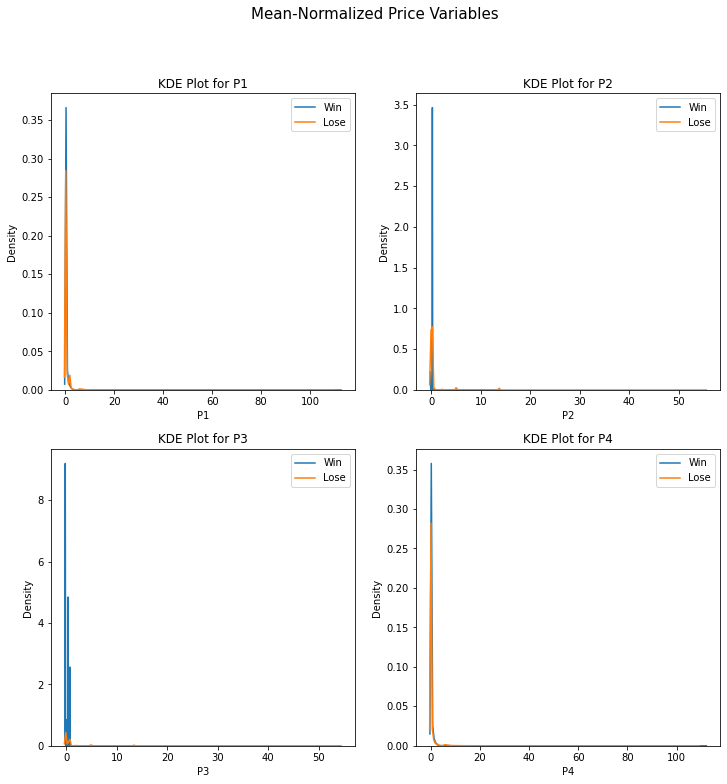

In [32]:
# Mean-Normalized
fig, axes = plt.subplots(2,2,figsize=(12,12))
for idx, col in enumerate(col_price):
    sns.kdeplot(df_norm_win[col], label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(df_norm_lose[col], label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.suptitle('Mean-Normalized Price Variables', fontsize=15)
plt.show() # 32.3s

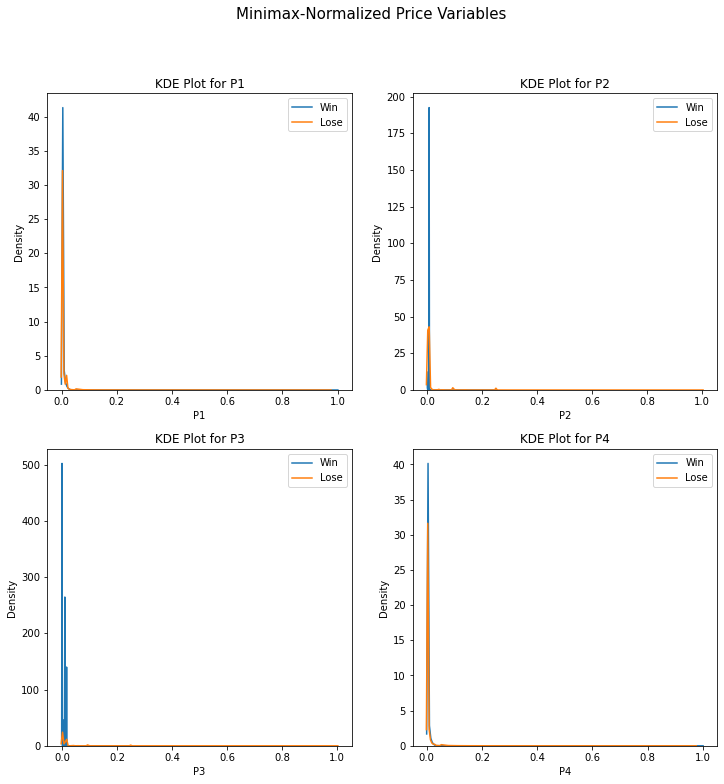

In [33]:
# Minimax-Normalized
fig, axes = plt.subplots(2,2,figsize=(12,12))
for idx, col in enumerate(col_price):
    sns.kdeplot(df_minmax_win[col], label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(df_minmax_lose[col], label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.suptitle('Minimax-Normalized Price Variables', fontsize=15)
plt.show() # 34.8s

#### 기존 분포에서는 낙찰/유찰 간 가격변수의 분포가 잘 구분되지 않음 > 로그변환 이용

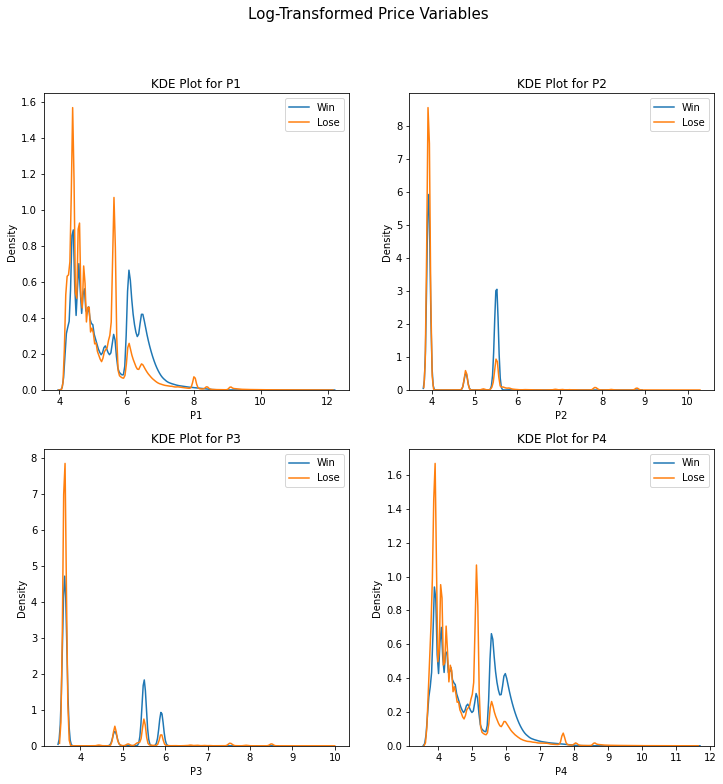

In [34]:
fig, axes = plt.subplots(2,2,figsize=(12,12))
for idx, col in enumerate(col_price):
    sns.kdeplot(np.log1p(df_win[col]), label='Win', ax=axes[idx//2, idx%2])
    sns.kdeplot(np.log1p(df_lose[col]), label='Lose', ax=axes[idx//2, idx%2])
    axes[idx//2,idx%2].legend()
    axes[idx//2,idx%2].set_title(f'KDE Plot for {col}')
plt.suptitle('Log-Transformed Price Variables', fontsize=15)
plt.show()

#### 최종 : P1-P4 데이터에 대해 log1p 변환 실행

In [35]:
for col in col_price:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

In [36]:
df_train.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl')

## Final Data type / Variable Name setting

In [37]:
df_train = pd.read_pickle('train.pkl')
df_test = pd.read_pickle('test.pkl')

In [39]:
colnames = ['Datetime', 'ADID_type', 'DSP_ID', 'Media_ID', 'Adunit_ID', 'Platform', 'OS_type', 'Size_ID',
       'Ex_Rate', 'Category', 'Country_ID', 'P1', 'P2', 'P3', 'P4', 'weekend',
       'hour', 'dayofweek']

In [40]:
df_train.columns = colnames + ['Class']
df_test.columns = colnames

In [41]:
col_int = ['ADID_type', 'DSP_ID', 'Media_ID', 'Adunit_ID', 'Platform', 'OS_type', 'Size_ID',
           'Country_ID', 'weekend', 'hour', 'dayofweek']

In [42]:
# Missing value at Country_ID > treat with Mode
df_train['Country_ID'] = df_train.Country_ID.fillna(df_train.Country_ID.mode()[0])
df_test['Country_ID'] = df_test.Country_ID.fillna(df_test.Country_ID.mode()[0])

In [43]:
# Set integer columns
df_train[col_int] = df_train[col_int].astype('int64')
df_test[col_int] = df_test[col_int].astype('int64')

In [ ]:
df_train.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl')

### Category Treatment
- 모든 서브카테고리까지 포함하기에는 너무 많은 variable 생성됨</br>
- 특정 Main Category(0~26, 0:NA)에 속하는 여부만 파악

In [ ]:
df_train = pd.read_pickle('train.pkl')
df_test = pd.read_pickle('test.pkl')

In [44]:
# Category fillna with str NA
df_train.Category = df_train.Category.fillna('NA')
df_test.Category = df_test.Category.fillna('NA')

In [46]:
# Category treatment
from tqdm import tqdm
import math

cat_train = []
cat_test = []

for i in tqdm(range(len(df_train))):
    cat_train.append(df_train.Category[i].split('%2C'))

print(len(cat_train))

for i in tqdm(range(len(df_test))):
    cat_test.append(df_test.Category[i].split('%2C'))

print(len(cat_test))

100%|██████████| 8525512/8525512 [00:55<00:00, 154956.27it/s]


8525512


100%|██████████| 624142/624142 [00:04<00:00, 140579.68it/s]

624142


In [59]:
st = 'IAB91-38'
int(st[3:st.find('-')])

91

In [56]:
st.find('-')

True

In [73]:
cat_train_treated = [] # for train
for ls in tqdm(cat_train):
    ls_treated = []
    for item in ls:
        if item == 'NA':
            ls_treated.append(0)
        else:
            if item.find('-') == -1:
                ls_treated.append(int(item[3:]))
            else:
                ls_treated.append(int(item[3:item.find('-')]))
    
    cat_train_treated.append(list(set(ls_treated))) # duplicate remove

print(len(cat_train_treated))

100%|██████████| 8525512/8525512 [00:18<00:00, 455811.65it/s] 

8525512


In [74]:
cat_test_treated = [] # for test
for ls in tqdm(cat_test):
    ls_treated = []
    for item in ls:
        if item == 'NA':
            ls_treated.append(0)
        else:
            if item.find('-') == -1:
                ls_treated.append(int(item[3:]))
            else:
                ls_treated.append(int(item[3:item.find('-')]))
    
    cat_test_treated.append(list(set(ls_treated))) # duplicate remove

print(len(cat_test_treated))

100%|██████████| 624142/624142 [00:00<00:00, 809377.63it/s]

624142


In [70]:
# To dummy Variable (as IAB_n)
for i in range(27):
    colname_i = 'IAB_' + str(i)
    df_train[colname_i] = 0
    df_test[colname_i] = 0

In [78]:
# For Train data
for idx, ls in tqdm(enumerate(cat_train_treated)):
    for item in ls:
        colname_i = 'IAB_' + str(item)
        df_train.iloc[idx, df_train.columns.get_loc(colname_i)] = 1

6953027it [04:00, 23837.32it/s]

In [79]:
# For Test data
for idx, ls in tqdm(enumerate(cat_test_treated)):
    for item in ls:
        colname_i = 'IAB_' + str(item)
        df_test.iloc[idx, df_test.columns.get_loc(colname_i)] = 1

624142it [00:21, 28791.77it/s]


In [82]:
df_train = df_train[df_train.columns.drop(['Category'])]
df_test = df_test[df_test.columns.drop(['Category'])]

In [96]:
df_train = df_train[df_train.columns.drop(['Class']).tolist()+['Class']] # Class 맨뒤로 보내기

In [97]:
df_train.to_pickle('train.pkl') 
df_test.to_pickle('test.pkl')